# 1. Importar librerias y leer el archivo houses_for_sale

In [89]:
#importar las librerias
import pandas as pd
import numpy as np 
from functools import reduce
import re

In [90]:
#leer el archivo
houses_for_sale = pd.read_csv(r"..\Datasets originales\Dataset_houses_for_sale.csv")
#revisar su forma
houses_for_sale.shape

(11269, 28)

# 2.Limpieza del dataset

### Eliminar columnas

Se eliminará ciertas columnas que no son importantes para el analisis que se realizará. En la columna source hay datos de los agentes de venta, en permalink vemos el las ciudades y estados que son datos que ya esta en las columnas, en other_listings vemos si la casa ya se ha vendido con anterioridad y open_houses se refiere a si la casa esta abierta a visitas, pero en la columna esta vacia, branding es una columna de la compañia que ofrece la propiedad,coming_soon_date es una columna con nan,  matterport es una forma de capturar imagenes en 3d,  search_promotions busca las promociones esta llena de valores nan, rent_to_own tiene valores nan, products se refiere a la propiedad como producto, virtual_tours si se cuenta con link a un tour virtual, community tiene todos sus valores nan, price_reduced_amount son los descuentos en los precios pero tambien  las columnas estan en nan, last_update_date es la fecha en que se actualizo la propiedad en la pagina web,lead_attributes son caracteristicas que son importantes para la web,tax_record es el registro de trinutos.

In [91]:
#columnas para eliminar con datos que no son relevantes
columns_to_drop=['source','permalink','other_listings','open_houses','branding','coming_soon_date','matterport','search_promotions',
                 'rent_to_own','products','virtual_tours','community','price_reduced_amount','last_update_date','lead_attributes', 'tax_record']

#eliminar las columas
houses_for_sale.drop(columns=columns_to_drop,inplace=True)

### Buscar filas duplicadas en la columna "description"

En la columna description se ven diferentes datos importantes, como el numero de baños, tamaño en pies,etc.
Se debe buscar en la columna description por valores que esten duplicados, los valores duplicados estan en forma de fila, una detras de otra

In [92]:
#crear una lista para guardas las filas que estan duplicadas

descriptions = []
#crear lita de id que estan repetidoas
ids=[]
for index, row in houses_for_sale.groupby('property_id')['description'].apply(list).reset_index().iterrows():
    id=str(row['property_id'])
    
    if len(row['description']) > 1:

        descriptions.append(row['description'])
        ids.append(id)
        if len(ids) >2:
            break


In [93]:
#los id_producto que estan con filas duplicadas
ids

#ver que filas son las duplicadas
descriptions[0]


print("las ids duplicadas son", ids)
print("las filas duplicadas son",descriptions[0])

las ids duplicadas son ['1034050928', '1117136034', '1156155585']
las filas duplicadas son ["{'sqft': 2963, 'baths_consolidated': '3', 'lot_sqft': 12876, 'sold_price': 66045, 'baths_3qtr': None, 'baths_full': 3, 'name': None, 'sold_date': '1978-11-07', 'sub_type': None, 'year_built': 1979, 'garage': 2, 'baths_half': None, 'baths': 3, 'baths_1qtr': None, 'stories': 1, 'beds': 4, 'type': 'single_family'}", "{'sqft': 2963, 'baths_consolidated': '3', 'lot_sqft': 12876, 'sold_price': 66045, 'baths_3qtr': None, 'baths_full': 3, 'name': None, 'sold_date': '1978-11-07', 'sub_type': None, 'year_built': 1979, 'garage': 2, 'baths_half': None, 'baths': 3, 'baths_1qtr': None, 'stories': 1, 'beds': 4, 'type': 'single_family'}"]


In [94]:
#ver que filas son duplicadas por id, son exactamente las mimas filas, estan duplicadas una detras de otra
# por eso hay que eliminar
houses_for_sale[houses_for_sale['property_id']== 1034050928]

,primary_photo,tags,list_date,description,photos,flags,list_price,property_id,location,listing_id,primary,status
276,{'href': 'https://ap.rdcpix.com/e578888ca31258...,"['community_outdoor_space', 'den_or_office', '...",2023-09-28T17:12:07Z,"{'sqft': 2963, 'baths_consolidated': '3', 'lot...",[{'href': 'https://ap.rdcpix.com/e578888ca3125...,"{'is_new_construction': None, 'is_subdivision'...",925000.0,1034050928,"{'address': {'postal_code': '85254', 'state': ...",2.960065e+09,True,for_sale
472,{'href': 'https://ap.rdcpix.com/e578888ca31258...,"['community_outdoor_space', 'den_or_office', '...",2023-09-28T17:12:07Z,"{'sqft': 2963, 'baths_consolidated': '3', 'lot...",[{'href': 'https://ap.rdcpix.com/e578888ca3125...,"{'is_new_construction': None, 'is_subdivision'...",925000.0,1034050928,"{'address': {'postal_code': '85254', 'state': ...",2.960065e+09,True,for_sale


In [95]:
#eliminar las columnas duplicadas
houses_for_sale.drop_duplicates(subset='property_id', inplace = True)
print("el tamaño del dataset es :",houses_for_sale.shape)



el tamaño del dataset es : (11234, 12)


### Funcion para columnas anidadas

Existen columnas que tienen diccionarios adentro, esos datos se deben sacar fuera de las columnas para formar mas columnas y elegir que datos usar para el analisis.
Se hizo una funcion para desanidar las columnas.

In [96]:
#columnas para desanidar
['primary_photo','source', 'tags', 'description','photos','flags','location']
#son columnas que esta anidadas, primary foto tien un url de las fotos, los flags son caraacteriticas de la construccion, los tags siven para 
# clasificar las propiedades, en  description estan algunas caracteristicas de las propiedades, photos tiene dos link de fotos de las prpiedades, 
#flags son caracteristicas de la construccion, y location contiene longitud, latitud, zipcode,etc.
#son importantes, 


['primary_photo',
 'source',
 'tags',
 'description',
 'photos',
 'flags',
 'location']

In [97]:
#definir una funcion para sacar los datos de las columnas que contiene cadenas que representan diccionarios

def data_processor(df, columnas, columna_target):
    
    # Inicializa una lista vacía llamada 'lista_dics_datos' para almacenar los datos transformados.
    lista_dics_datos = []
    
    # Itera a través de las filas del DataFrame 'df'.
    for _, row in df.iterrows():
        
        # Extrae el 'property_id' pues es unico en el dataframe de la fila actual.
        property_id = row['property_id']
            
        # Itera a través de los elementos en la columna especificada por 'columna_target'.
        for elemento in row[columna_target]:

            if elemento is not None:
                try:
                    # Crea un nuevo diccionario 'elemento_data' que contiene la información de la fila actual.
                    elemento_data = eval(elemento).copy()
                except:
                    elemento_data = elemento.copy()
            else:
                elemento_data = {}
                
            # Agrega información adicional al diccionario 'elemento_data'.
            elemento_data['property_id'] = property_id       
                       
            # Agrega el diccionario 'review_data' a la lista 'listadatos'.
            lista_dics_datos.append(elemento_data)

    # Crea un nuevo DataFrame 'df_limpio' a partir de la lista 'lista_dics_datos'
    # utilizando las columnas especificadas en 'columnas'.
    df_limpio = pd.DataFrame(lista_dics_datos, columns=columnas)
    
    # Devuelve el nuevo DataFrame 'df_limpio'.
    return df_limpio


### Aplicar la funcion en la columna "description"

Hay que aplicar la funciones de la celda anterior para realmente desanidar a las columnas.

In [98]:
#separar la columna description para poder transformarla
df = houses_for_sale.groupby('property_id')['description'].apply(list).reset_index()

#definir una lista de columnas
columns = ['property_id']

#añadir las columnas que estan dentro de description a la base de datos como columnas
columns +=[x for x in eval(df['description'][0][0]).keys()]

#aplicar la funcion de desanidar 
df_temporal = data_processor(df,columns,'description')

#unir los datasets
df_final = pd.merge(df_temporal,houses_for_sale, on='property_id')

#eliminar la columna description pues ya se desanido
dropeable_columns = [ 'description']
df_final.drop(columns=dropeable_columns, inplace = True)

df_final.head()

,property_id,sqft,baths_consolidated,lot_sqft,sold_price,baths_3qtr,baths_full,name,sold_date,sub_type,...,primary_photo,tags,list_date,photos,flags,list_price,location,listing_id,primary,status
0,1000163193,1111.0,2,5000.0,288000.0,NaN,2.0,None,2003-04-28,None,...,{'href': 'https://ap.rdcpix.com/c40746b359c3d7...,"['central_air', 'community_outdoor_space', 'di...",2023-09-16T13:57:33Z,[{'href': 'https://ap.rdcpix.com/c40746b359c3d...,"{'is_new_construction': None, 'is_subdivision'...",899000.0,"{'address': {'postal_code': '94804', 'state': ...",2.959741e+09,True,for_sale
1,1000748625,3126.0,3,10454.0,725000.0,2.0,1.0,None,2021-08-02,None,...,{'href': 'https://ap.rdcpix.com/7501bd1b85a32e...,"['basement', 'community_outdoor_space', 'dinin...",2023-09-27T18:18:34Z,[{'href': 'https://ap.rdcpix.com/7501bd1b85a32...,"{'is_new_construction': None, 'is_subdivision'...",870000.0,"{'address': {'postal_code': '98208', 'state': ...",2.960037e+09,True,for_sale
2,1001237574,3836.0,3.5,15284.0,1171796.0,NaN,3.0,None,2020-01-28,None,...,{'href': 'https://ap.rdcpix.com/fd492f6878f09c...,"['community_boat_facilities', 'community_golf'...",2023-09-27T05:04:46Z,[{'href': 'https://ap.rdcpix.com/fd492f6878f09...,"{'is_new_construction': None, 'is_subdivision'...",1899000.0,"{'address': {'postal_code': '85383', 'state': ...",2.960018e+09,True,for_sale
3,1001483948,2200.0,3,6098.0,150000.0,NaN,3.0,None,1992-09-15,None,...,{'href': 'https://ap.rdcpix.com/0487398867f4fd...,"['central_air', 'central_heat', 'city_view', '...",2023-09-26T02:13:06Z,[{'href': 'https://ap.rdcpix.com/0487398867f4f...,"{'is_new_construction': None, 'is_subdivision'...",679000.0,"{'address': {'postal_code': '92591', 'state': ...",2.959985e+09,True,for_sale
4,1001489359,856.0,1,4264.0,490000.0,NaN,1.0,None,2005-06-21,None,...,{'href': 'https://ap.rdcpix.com/8926b1a848f534...,"['community_outdoor_space', 'den_or_office', '...",2023-09-26T22:10:29Z,[{'href': 'https://ap.rdcpix.com/8926b1a848f53...,"{'is_new_construction': None, 'is_subdivision'...",799000.0,"{'address': {'postal_code': '94602', 'state': ...",2.960011e+09,True,for_sale


### Limpiar columnas "dates"

se debe limpiar las columnas de fechas pues tienen un formato diferente que hay que cambiar, extraer solo los numeros de la fecha pues las fechas tienen letras y numeros.

In [99]:
#funcion para convretir las fechas a datetime 
def convert_date(text):
    try:
        return pd.to_datetime(text, errors='raise')
    except ValueError:
        return np.nan

In [100]:
#aplicar la funciona a la columna sold_date
df_final['sold_date']=df_final['sold_date'].apply(convert_date)

#imprimir las columnas que son unicas
print(len(df_final['sold_date'].unique()))

#usar los datos de esta base de datos para entrenar el otro modelo de casas vendidas
df_final[df_final['sold_date'].notna()].to_csv('Df_sold_homes_to_train.csv')

4177


In [101]:
#eliminar las columnas que ya no se usaran 
columns_to_drop = ['sold_date', 'sold_price', 'name','sub_type']
df_final.drop(columns=columns_to_drop, inplace= True)

In [102]:
#Quitar las letras de la fecha en list_date
df_final['list_date']=(df_final['list_date'].astype(str).str.split('T')).str[0]

#convertir list_date eb datetime
df_final['list_date'] = df_final['list_date'].apply(convert_date)

### Desanidar columnas 'flags','location'

La columna flags tiene mucha informacion como: caracteristicas de la construccion, si tiene diviones, si es nueva la construccion, si tiene planos.
La columna location tiene informacion como estado, coordenadas,ciudad

In [103]:
#mostar las columnas que son str
for column in df_final.columns:
    if type(df_final[column][2]) is str:
        print( column , df_final[column][2]+'\n')

baths_consolidated 3.5

type single_family

primary_photo {'href': 'https://ap.rdcpix.com/fd492f6878f09cbe6eda231a8fcceb73l-m763238679s-w1024_h768.jpg'}

tags ['community_boat_facilities', 'community_golf', 'community_outdoor_space', 'community_security_features', 'den_or_office', 'energy_efficient', 'fireplace', 'golf_course_lot_or_frontage', 'golf_course_view', 'laundry_room', 'pets_allowed', 'recreation_facilities', 'view', 'single_story', 'garage_1_or_more', 'garage_2_or_more', 'garage_3_or_more', 'gourmet_kitchen', 'high_ceiling', 'wine_cellar', 'gated_community', 'clubhouse', 'golf_course', 'views', 'groundscare', 'security']

photos [{'href': 'https://ap.rdcpix.com/fd492f6878f09cbe6eda231a8fcceb73l-m763238679s-w1024_h768.jpg'}, {'href': 'https://ap.rdcpix.com/fd492f6878f09cbe6eda231a8fcceb73l-m3583859794s-w1024_h768.jpg'}]

flags {'is_new_construction': None, 'is_subdivision': None, 'is_plan': None, 'is_price_reduced': None, 'is_pending': None, 'is_foreclosure': None, 'is_new_li

In [104]:
#ver las columnas que tienen diccionarios por dentro
df_final[['primary_photo','tags','photos','flags','location']].head()

,primary_photo,tags,photos,flags,location
0,{'href': 'https://ap.rdcpix.com/c40746b359c3d7...,"['central_air', 'community_outdoor_space', 'di...",[{'href': 'https://ap.rdcpix.com/c40746b359c3d...,"{'is_new_construction': None, 'is_subdivision'...","{'address': {'postal_code': '94804', 'state': ..."
1,{'href': 'https://ap.rdcpix.com/7501bd1b85a32e...,"['basement', 'community_outdoor_space', 'dinin...",[{'href': 'https://ap.rdcpix.com/7501bd1b85a32...,"{'is_new_construction': None, 'is_subdivision'...","{'address': {'postal_code': '98208', 'state': ..."
2,{'href': 'https://ap.rdcpix.com/fd492f6878f09c...,"['community_boat_facilities', 'community_golf'...",[{'href': 'https://ap.rdcpix.com/fd492f6878f09...,"{'is_new_construction': None, 'is_subdivision'...","{'address': {'postal_code': '85383', 'state': ..."
3,{'href': 'https://ap.rdcpix.com/0487398867f4fd...,"['central_air', 'central_heat', 'city_view', '...",[{'href': 'https://ap.rdcpix.com/0487398867f4f...,"{'is_new_construction': None, 'is_subdivision'...","{'address': {'postal_code': '92591', 'state': ..."
4,{'href': 'https://ap.rdcpix.com/8926b1a848f534...,"['community_outdoor_space', 'den_or_office', '...",[{'href': 'https://ap.rdcpix.com/8926b1a848f53...,"{'is_new_construction': None, 'is_subdivision'...","{'address': {'postal_code': '94602', 'state': ..."


In [105]:

def unraveler(df, target_columns:list):
    #crear una lista vacia para almacenar los datasets
    dfs_temporales =[]
    
    #iterar sobre las columnas de target_columns
    for column in target_columns:
        
        #crear un dataset con agrupado por property id pero de acuerdo a cada columna de la lista de columnas
        df_grouped = df.groupby('property_id')[column].apply(list).reset_index()
        
        #crear una lista de nombres de columnas
        columns = ['property_id']
        
        #aumentar en cada lista los valores que estan dentro de los diccionarios anidados
        try:
            columns +=[x for x in eval(df_grouped[column][0][0]).keys()]
        except:
            columns +=[x for x in (df_grouped[column][0][0]).keys()]
        
        #aplicar la funcion para desanidar
        df_temporal = data_processor(df_grouped,columns,column)
        dfs_temporales.append(df_temporal)
    
    # combinar los dataframes en uno nuevo
    resultado = reduce(lambda left, right: pd.merge(left, right, on='property_id'), dfs_temporales)
    
    #combinar los dataframe por la columna property_id
    resultado = pd.merge(resultado,df, on='property_id')
    return resultado
    

In [106]:
#columnas a convertir
columns = ['flags','location']

#aplicar la funcion para desanidar
df_final = unraveler(df_final, columns)

#eliminar columnas nuevas que salieron de los diccionarios que se desanidaron
df_final.drop(columns=['is_new_listing','is_pending','flags','location',"is_subdivision"], inplace = True)

### Limpieza de las columnas que contengan la palabra "baths

Existen varias columnas relacionadas con la palabra baths, primero hay que limpiarlos y luego eliminar las columnas que no sirven.

In [107]:
# Utiliza expresiones regulares para encontrar todos los números en la cadena.
def extraer_numeros(cadena):
    
    # El patrón \d+\.\d+|\d+ busca números enteros o decimales en la cadena.
    numeros_encontrados = re.findall(r'\d+\.\d+|\d+', str(cadena))
    
    # Si se encuentran números en la cadena:
    if numeros_encontrados:
        # Une los números encontrados utilizando comas y devuelve la cadena resultante.
        return ','.join(numeros_encontrados)
    
    # Si no se encuentran números en la cadena, devuelve 0.
    return np.nan

In [108]:
#la columa de baños se debe convertir a numeros
df_final['baths_consolidated'] = df_final['baths_consolidated'].apply(extraer_numeros)

#la columa de baños se convierte en float
df_final['baths_consolidated'] = df_final['baths_consolidated'].apply(float)

In [109]:
#se va a limpiar las columnas que contengan la palabra bath

#hacer una lista
bath_columns= []
#iterar en la columna para hacer la lista
for column in df_final.columns:
    if 'bath' in column:
        bath_columns.append(column)

#iterar en la lista creada para saber cuales tienen mas datos utiles en sus columnas
for column in bath_columns:
    #buscar en el dataframe tal que la columna baths_consolidated tenga datos nan para ver si se puede rellenar los faltantes
    for num in df_final[df_final['baths_consolidated'].isna()==True][column]:
        if num > 0:
            print(num)

#no existen datos validos por lo que se van a eliminar las columnas 

In [110]:
#Eliminar de la lista la columna baths_consolidated
bath_columns.remove('baths_consolidated')

#Eliminar las columnas de que tengan bath
df_final.drop(bath_columns, axis=1, inplace=True)

#renombar la columna
df_final=df_final.rename(columns={"baths_consolidated":"baths"})

### Limpiar columnas "tags"

la columna tags contiene tags que dan caracteristicas especificas de la propiedad, lo que se debe hacer con los tags es solo coger los que son mas comunes 

In [111]:
#ver que columnas son de tipo str
for column in df_final.columns:
    if type(df_final[column][2]) is str:
        print( f'{column}' , df_final[column][2]+'\n')

street_view_url https://maps.googleapis.com/maps/api/streetview?channel=rdc-streetview&client=gme-movesalesinc&location=31010%20N%20117th%20Dr%2C%20Peoria%2C%20AZ%2085383&size=640x480&source=outdoor&signature=UWiFqjBXrMeXn8KQlA5gWBuNatU=

type single_family

primary_photo {'href': 'https://ap.rdcpix.com/fd492f6878f09cbe6eda231a8fcceb73l-m763238679s-w1024_h768.jpg'}

tags ['community_boat_facilities', 'community_golf', 'community_outdoor_space', 'community_security_features', 'den_or_office', 'energy_efficient', 'fireplace', 'golf_course_lot_or_frontage', 'golf_course_view', 'laundry_room', 'pets_allowed', 'recreation_facilities', 'view', 'single_story', 'garage_1_or_more', 'garage_2_or_more', 'garage_3_or_more', 'gourmet_kitchen', 'high_ceiling', 'wine_cellar', 'gated_community', 'clubhouse', 'golf_course', 'views', 'groundscare', 'security']

photos [{'href': 'https://ap.rdcpix.com/fd492f6878f09cbe6eda231a8fcceb73l-m763238679s-w1024_h768.jpg'}, {'href': 'https://ap.rdcpix.com/fd492f68

In [112]:
##funcion para evaluar los nan en la columna tags
def safe_eval(expression):
    try:
        result = eval(expression)
        return result
    except Exception as e:

        if expression is np.nan:
            return expression
        else:
            
            print(f"Error en la evaluación: {e}, and was given {expression}")
            return expression


In [113]:
#se aplica la funcion a la columna tags
df_final['tags'] = df_final['tags'].apply(safe_eval)

In [114]:
#poner en lista cada una de las filas de la columna tags
def get_tags(list):
    
    my_list = []
    try:
        for tag in list:
            my_list.append(tag)
        return my_list 
    except:
        return my_list

In [115]:
#Aplicar la funciona a cada fila de la columna tags
tags = []
#recorre cada fila del datafram para sacar los tags
for index, row in df_final.iterrows():
    
    tag=get_tags(row['tags'])

    tags+=tag

In [116]:
#imprimir los resultados
print("el total de tags es:",len(tags))
print("los tags unicos son:",len(set(tags)))

el total de tags es: 127814
los tags unicos son: 168


### Definir los tags mas vendidos

In [117]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#se va a hacer un wordcloud para saber cuales son los tags mas usados
# Tu lista de palabras
lista_de_palabras = tags
# Convierte la lista en una cadena de texto
texto = " ".join(lista_de_palabras)


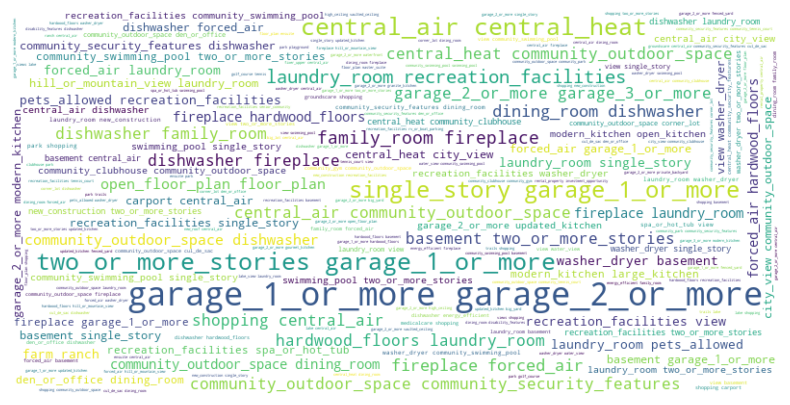

In [118]:
# Crea un objeto WordCloud
nube_de_palabras = WordCloud(width=800, height=400, background_color='white').generate(texto)

# Muestra la nube de palabras utilizando Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(nube_de_palabras, interpolation='bilinear')
plt.axis("off")
plt.show()


In [119]:
#para eliminar las tags que son las mas frecuentes 
Start_tags=0
current_tags=1
while Start_tags != current_tags:
    Start_tags=len(tags)
    for tag in tags:
        #eliminar las palabras garage y story pues ya son parte del dataframe
        if 'garage' in tag or 'story' in tag or 'stories' in tag:
            tags.remove(tag)
    current_tags=len(tags)

In [120]:
#definir los tags unicos que hay en tags
tags_unicos ={}
#recorrer los tags para sacar un diccionario con los nombres y cantidad de tags
for tag in tags:
    if tag not in tags_unicos.keys():
        tags_unicos[tag]=tags.count(tag)
    else:
        tags.remove(tag)

#poner el resultado del diccionario en un dataframe
top_50_tags = pd.DataFrame(tags_unicos.values(),tags_unicos.keys()).sort_values(by=0,ascending=False).head(50).rename(columns={0:'count'})

### Desanidar las columnas 'address',"county","photos" 

quedan pendientes de desanidar tres columnas, La columna address tiene informacion de la localizacion de la propiedad, la columna country tiene informacion que usa el estado para localizar las propiedades, la columna photos tiene dos url de fotos de la propiedad de esta columna solo se cogerá la segunda fotos pues la primera ya se encuntra en la columna photo

In [121]:
#columnas a convertir
columns = ['address',"county"]

#aplicar la funcion para desanidar
df_final = unraveler(df_final, columns)

#aplicar a la columna que se desanido a partir de adress
df_final = unraveler(df_final,['coordinate'])

#eliminar las columnas que ya se trabajaron
df_final.drop(columns=['coordinate','county','address'], inplace=True)

In [125]:

#aplicar la funcion safe eval para preparar la columna photos para desanidarla
df_final['photos'] = df_final['photos'].apply(safe_eval)


#funcion para obtener de la columna photos el segundo link de la foto, le primero ya se tiene en la columna photo
def get_second_photo(list):
    try:
        #toma el segundo link de foto
        list=list[1]
        #toma el link sin la palabra href previo al url
        list=list['href']
        return list
        
        #sino encuentra un segundo link, toma el primero
    except:
        try:
            list=list[0]
            list = list['href']
            return list 
        except:
            
            return list



#aplicar la funcion para sacar la segunda foto    
df_final['photos'] = df_final['photos'].apply(get_second_photo)


In [126]:
#funcion para sacar el url de la columna primary photo
def get_photo(list):
    try:
        list = list['href']
        return list 
    except:
            
        return list

#aplicar la funcion a la columna primary photo
df_final['primary_photo'] = df_final['primary_photo'].apply(safe_eval)
df_final['primary_photo'] = df_final['primary_photo'].apply(get_photo)

La funcion info nos da una idea de la calidad de datps, de las 33 columnas existen columnas que contienen varios datos nulos. De los datos que se quedaron se deben continuar limpiando de acuerdo a lo que se necesite en el modelo de ML, en el dashboard. 

In [128]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11234 entries, 0 to 11233
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   property_id          11234 non-null  int64         
 1   lon                  10937 non-null  float64       
 2   lat                  10937 non-null  float64       
 3   postal_code          11234 non-null  object        
 4   state                11212 non-null  object        
 5   city                 11231 non-null  object        
 6   state_code           11234 non-null  object        
 7   line                 11193 non-null  object        
 8   fips_code            10620 non-null  object        
 9   name                 11217 non-null  object        
 10  is_new_construction  1542 non-null   object        
 11  is_plan              648 non-null    object        
 12  is_price_reduced     219 non-null    object        
 13  is_foreclosure       19 non-nul

In [129]:
df_final.to_csv('Houses_for_sale_processed.csv',index = False)